Prediction Results for 2024-10-01 to 2024-12-31:

          date  actual_tests  predicted_tests
0   2024-10-01            10                4
1   2024-10-02             0               12
2   2024-10-03             0                5
3   2024-10-04            42                7
4   2024-10-05             3                8
5   2024-10-06             5                9
6   2024-10-07            93               79
7   2024-10-08             2                6
8   2024-10-09            76              104
9   2024-10-10            34                4
10  2024-10-11             2               23
11  2024-10-12             3                8
12  2024-10-13            30                8
13  2024-10-14            22               17
14  2024-10-15             9               10
15  2024-10-16             2               11
16  2024-10-17             5                6
17  2024-10-18             0                6
18  2024-10-19             0                5
19  2024-10-20            39  

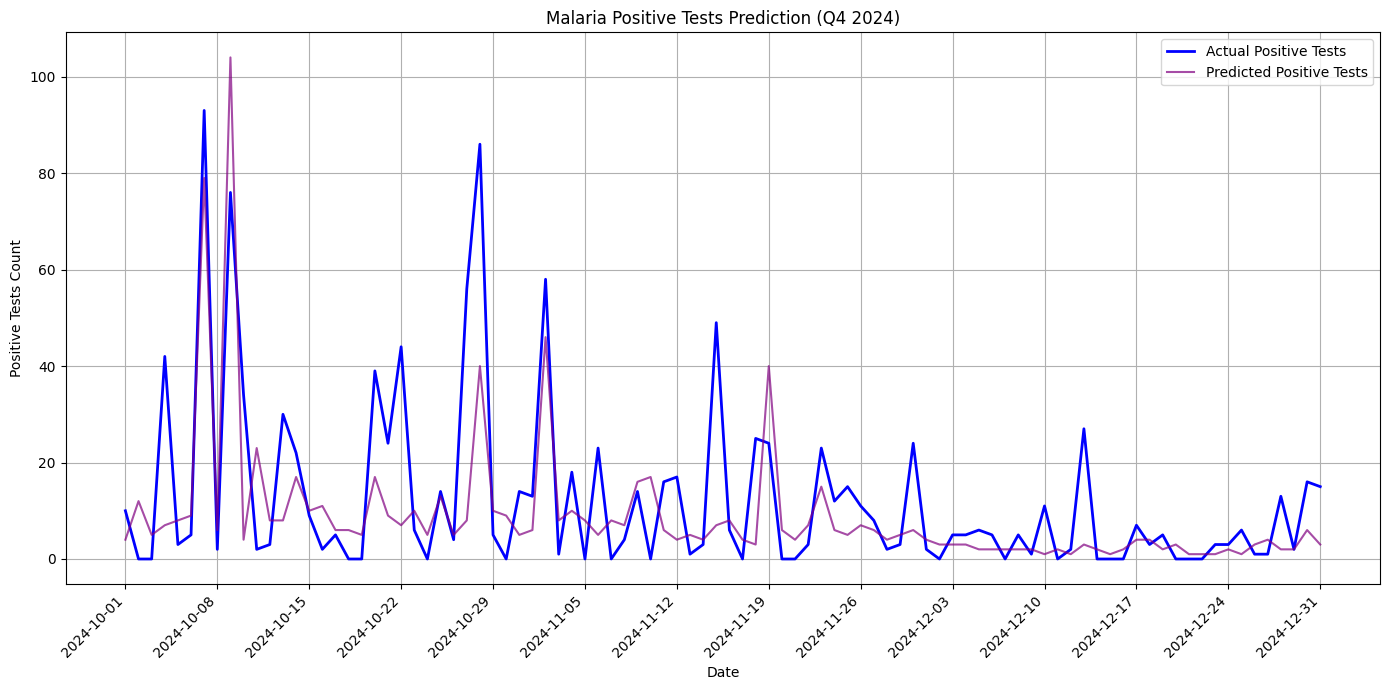

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# --- 0. Colab File Upload (Placeholder) ---
# NOTE: If you are running this in Google Colab, uncomment and run the following lines
# to upload your files. This code assumes the files are named exactly:
# 'malaria lab test.csv', 'pharmacy.csv', and 'Jinnah Pharmacy 2.csv'.

# from google.colab import files
# uploaded = files.upload()
# # After upload, the files will be accessible by their names for loading below.
# # You may need to restart the notebook runtime if you encounter file not found errors.


# --- 1. Constants and Feature Engineering Function ---
LAGS = 14
FEATURES_TO_LAG = ['positive_tests', 'Coartem', 'Fansidar']
TRAIN_END_DATE = '2024-09-30'
PREDICT_START_DATE = '2024-10-01'
PREDICT_END_DATE = '2024-12-31'

def create_features_with_current_sales(df, features_to_lag, lags):
    """
    Generates time series features.

    Includes lagged positive tests (log1p scale), lagged sales, and current day
    sales (t=0) which will be added explicitly to the feature list later.
    """
    df_feat = df.copy()

    # Create lagged features for all relevant columns
    for col in features_to_lag:
        for lag in range(1, lags + 1):
            if col == 'positive_tests':
                # Lag positive_tests on log scale
                df_feat[f'{col}_lag{lag}'] = np.log1p(df_feat[col]).shift(lag)
            else:
                # Lag sales data on original scale
                df_feat[f'{col}_lag{lag}'] = df_feat[col].shift(lag)

    # Rolling Mean features for positive_tests (used as general trend indicators)
    df_feat['pos7'] = df_feat['positive_tests'].shift(1).rolling(window=7).mean()
    df_feat['pos14'] = df_feat['positive_tests'].shift(1).rolling(window=14).mean()

    # Date features
    df_feat['dow'] = df_feat['date'].dt.dayofweek
    df_feat['dom'] = df_feat['date'].dt.day
    df_feat['month'] = df_feat['date'].dt.month

    # Target variable (log transformed)
    df_feat['y'] = np.log1p(df_feat['positive_tests'])

    # Drop initial rows with NaN values resulting from lagging
    df_feat.dropna(inplace=True)
    return df_feat

# --- 2. Data Loading and Merging ---

# Load Lab Test Data
df_lab = pd.read_csv('malaria lab test.csv')
df_lab['date'] = pd.to_datetime(df_lab['date'], format='%d/%m/%Y', errors='coerce')
df_lab = df_lab[['date', 'positive_tests']]

# Load and Combine Pharmacy Data (Coartem, Fansidar sales)
df_pharmacy_2023 = pd.read_csv('pharmacy.csv')
df_pharmacy_2023['date'] = pd.to_datetime(df_pharmacy_2023['date'], format='%m/%d/%Y', errors='coerce')
df_pharmacy_2024 = pd.read_csv('Jinnah Pharmacy 2.csv')
df_pharmacy_2024['date'] = pd.to_datetime(df_pharmacy_2024['date'], format='%Y-%m-%d', errors='coerce')

df_sales_combined = pd.concat([df_pharmacy_2023, df_pharmacy_2024], ignore_index=True)
df_sales_combined = df_sales_combined[df_sales_combined['medicine'].isin(['Coartem', 'Fansidar'])]
df_sales_pivot = df_sales_combined.pivot_table(
    index='date', columns='medicine', values='sale', aggfunc='sum'
).reset_index()

# Merge all data
df_master = pd.merge(df_lab, df_sales_pivot, on='date', how='inner')
df_master.sort_values('date', inplace=True)
df_master.reset_index(drop=True, inplace=True)

# --- 3. Feature Engineering and Model Split ---
df_features = create_features_with_current_sales(df_master, FEATURES_TO_LAG, LAGS)

# Split into Training and Prediction (Test) sets
df_train = df_features[df_features['date'] <= TRAIN_END_DATE].copy()
df_predict = df_features[
    (df_features['date'] >= PREDICT_START_DATE) & (df_features['date'] <= PREDICT_END_DATE)
].copy()

# Define feature columns: Include lagged features + CURRENT DAY SALES ('Coartem', 'Fansidar')
feature_cols = [col for col in df_train.columns if col.startswith(('positive_tests_lag', 'Coartem_lag', 'Fansidar_lag', 'pos7', 'pos14', 'dow', 'dom', 'month'))]
feature_cols.extend(['Coartem', 'Fansidar']) # <-- Current Day Sales

X_train = df_train[feature_cols]
y_train = df_train['y']
X_predict_base = df_predict[feature_cols].copy()
actual_values = df_predict[['date', 'positive_tests']].copy()

# --- 4. Train Random Forest Regressor ---
# We use n_estimators=300 for a stable prediction.
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=42)
rf_regressor.fit(X_train, y_train)

# --- 5. Recursive Prediction Loop ---
df_pred_results = actual_values.copy()
df_pred_results.set_index('date', inplace=True)
df_pred_results.rename(columns={'positive_tests': 'actual_tests'}, inplace=True)
df_pred_results['predicted_tests'] = np.nan

for i in range(len(df_pred_results)):
    date_i = df_pred_results.index[i]
    current_features = X_predict_base.iloc[[i]].copy()

    # If not the first day, update the lagged positive tests recursively
    if i > 0:
        # Get last day's prediction (from previous iteration)
        pred_val_yesterday = df_pred_results['predicted_tests'].iloc[i-1]
        log_pred_yesterday = np.log1p(pred_val_yesterday)

        # Update positive_tests lags: shift all existing lags by 1
        for lag in range(LAGS, 1, -1):
            current_features[f'positive_tests_lag{lag}'] = current_features[f'positive_tests_lag{lag-1}']

        # Set the new lag1 feature to the previous day's log-transformed prediction
        current_features['positive_tests_lag1'] = log_pred_yesterday

    # The current day sales ('Coartem', 'Fansidar') are already fixed in 'current_features'
    # based on the prepared X_predict_base (actual sales data).

    # Predict the log of positive tests for the current day (i)
    log_pred_i = rf_regressor.predict(current_features)[0]

    # Convert prediction back to actual count (expm1) and ensure non-negative integer
    pred_i = np.expm1(log_pred_i)
    pred_i = max(0, round(pred_i))

    # Store the prediction
    df_pred_results.loc[date_i, 'predicted_tests'] = pred_i

# --- 6. Output Generation ---

# Final preparation for output table
df_comp = df_pred_results.reset_index()
df_comp['predicted_tests'] = df_comp['predicted_tests'].astype(int)
df_comp['actual_tests'] = df_comp['actual_tests'].astype(int)
df_comp['date'] = df_comp['date'].dt.strftime('%Y-%m-%d')

print(f"Prediction Results for {PREDICT_START_DATE} to {PREDICT_END_DATE}:\n")
print(df_comp[['date', 'actual_tests', 'predicted_tests']].to_string())


# --- 7. Plotting ---

plt.figure(figsize=(14, 7))
plt.plot(df_pred_results.index, df_pred_results['actual_tests'], label='Actual Positive Tests', color='blue', linewidth=2)
plt.plot(df_pred_results.index, df_pred_results['predicted_tests'], label='Predicted Positive Tests', color='purple', linestyle='-', alpha=0.7)
plt.title(f'Malaria Positive Tests Prediction (Q4 2024)')
plt.xlabel('Date')
plt.ylabel('Positive Tests Count')
plt.legend()
plt.grid(True)
plt.xticks(df_pred_results.index[::7], rotation=45, ha='right')
plt.tight_layout()
plt.savefig('rf_current_sales_final_prediction.png')
print("\nGraph saved as rf_current_sales_final_prediction.png")

Mean Absolute Error (MAE) for Q4 2024: 9.88
Prediction Results for 2024-10-01 to 2024-12-31 (Q4 2024):

          date  actual_tests  predicted_tests
0   2024-10-01            10                3
1   2024-10-02             0               16
2   2024-10-03             0                6
3   2024-10-04            42                8
4   2024-10-05             3                8
5   2024-10-06             5                7
6   2024-10-07            93               90
7   2024-10-08             2                4
8   2024-10-09            76              107
9   2024-10-10            34                7
10  2024-10-11             2               30
11  2024-10-12             3                9
12  2024-10-13            30                9
13  2024-10-14            22               19
14  2024-10-15             9                8
15  2024-10-16             2               15
16  2024-10-17             5                9
17  2024-10-18             0                8
18  2024-10-19        

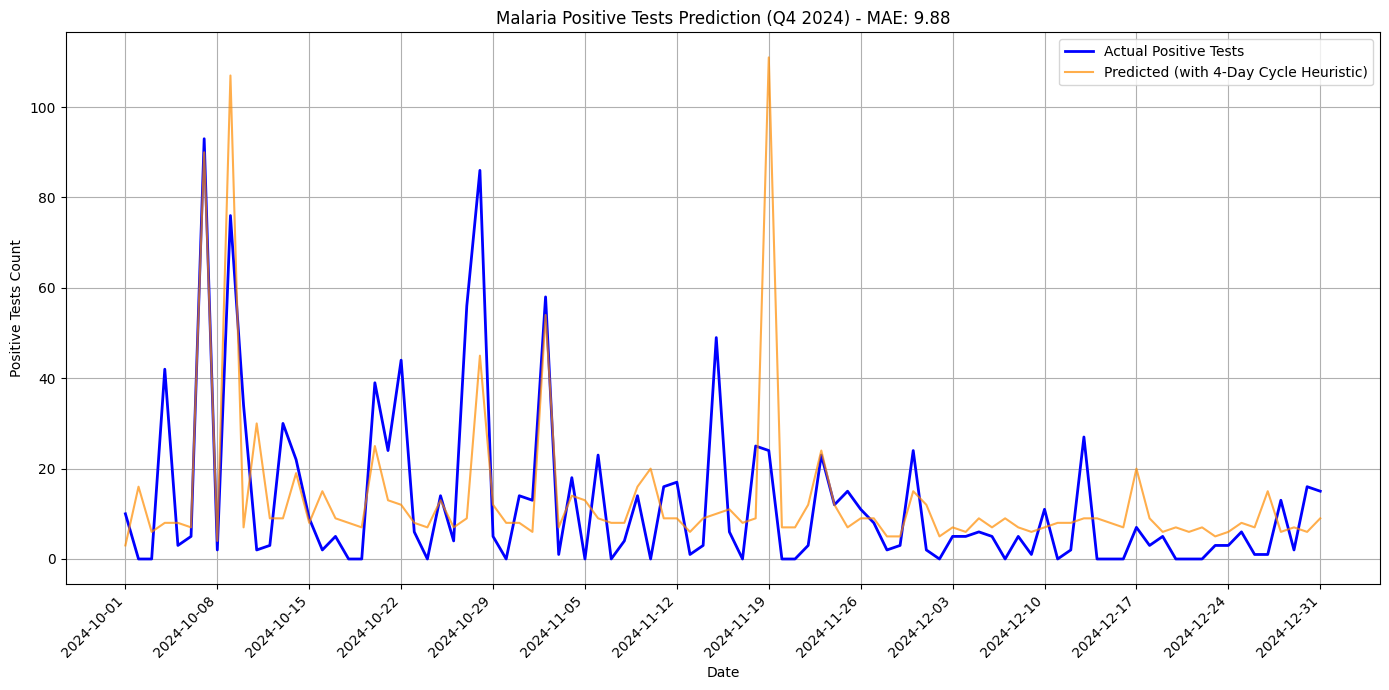

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from datetime import timedelta

# --- 1. Constants and Feature Engineering Function ---
LAGS = 14
FEATURES_TO_LAG = ['positive_tests', 'Coartem', 'Fansidar']
PEAK_TESTS_THRESHOLD = 100 # Threshold to define a peak day for the cycle heuristic
PEAK_CYCLE_THRESHOLD = 4 # Derived from 2024 surge data

def create_initial_features(df, features_to_lag, lags):
    """Generates core time series features (lags, rolling means, date features)."""
    df_feat = df.copy()

    # Lagged features (positive_tests are log-transformed)
    for col in features_to_lag:
        for lag in range(1, lags + 1):
            if col == 'positive_tests':
                df_feat[f'{col}_lag{lag}'] = np.log1p(df_feat[col]).shift(lag)
            else:
                df_feat[f'{col}_lag{lag}'] = df_feat[col].shift(lag)

    # Rolling Mean features
    df_feat['pos7'] = df_feat['positive_tests'].shift(1).rolling(window=7).mean()
    df_feat['pos14'] = df_feat['positive_tests'].shift(1).rolling(window=14).mean()

    # Date features
    df_feat['year'] = df_feat['date'].dt.year
    df_feat['month'] = df_feat['date'].dt.month
    df_feat['dow'] = df_feat['date'].dt.dayofweek
    df_feat['dom'] = df_feat['date'].dt.day

    # Target variable (log transformed)
    df_feat['y'] = np.log1p(df_feat['positive_tests'])

    # Drop initial rows with NaN values resulting from lagging
    df_feat.dropna(inplace=True)
    return df_feat

# --- 2. Data Loading and Merging ---

# Load Lab Test Data
df_lab = pd.read_csv('malaria lab test.csv')
df_lab['date'] = pd.to_datetime(df_lab['date'], format='%d/%m/%Y', errors='coerce')
df_lab = df_lab[['date', 'positive_tests']]

# Load and Combine Pharmacy Data (Coartem, Fansidar sales)
df_pharmacy_2023 = pd.read_csv('pharmacy.csv')
df_pharmacy_2023['date'] = pd.to_datetime(df_pharmacy_2023['date'], format='%m/%d/%Y', errors='coerce')
df_pharmacy_2024 = pd.read_csv('Jinnah Pharmacy 2.csv')
df_pharmacy_2024['date'] = pd.to_datetime(df_pharmacy_2024['date'], format='%Y-%m-%d', errors='coerce')

df_sales_combined = pd.concat([df_pharmacy_2023, df_pharmacy_2024], ignore_index=True)
df_sales_combined = df_sales_combined[df_sales_combined['medicine'].isin(['Coartem', 'Fansidar'])]
df_sales_pivot = df_sales_combined.pivot_table(
    index='date', columns='medicine', values='sale', aggfunc='sum'
).reset_index()

# Merge all data
df_master = pd.merge(df_lab, df_sales_pivot, on='date', how='inner')
df_master.sort_values('date', inplace=True)
df_master.reset_index(drop=True, inplace=True)


# --- 3. Feature Engineering and Model Split ---
df_features = create_initial_features(df_master, FEATURES_TO_LAG, LAGS)

# Define split
TRAIN_END_DATE = '2024-09-30'
PREDICT_START_DATE = '2024-10-01'
PREDICT_END_DATE = '2024-12-31'

df_train_base = df_features[df_features['date'] <= TRAIN_END_DATE].copy()
df_predict = df_features[
    (df_features['date'] >= PREDICT_START_DATE) & (df_features['date'] <= PREDICT_END_DATE)
].copy()

# Heuristic Feature Creation for Training Set
# Define a function to calculate time difference from the last observed peak
def calculate_time_since_last_peak(row, peak_dates_series):
    past_peaks = peak_dates_series[peak_dates_series <= row['date']]
    if past_peaks.empty:
        return np.nan
    last_peak_date = past_peaks.max()
    return (row['date'] - last_peak_date).days

# Find actual peak days (shifted by 1 day to be a predictor)
df_train_base['peak_day'] = (df_train_base['positive_tests'].shift(1) > PEAK_TESTS_THRESHOLD).astype(int)
peak_dates_train = df_train_base.loc[df_train_base['peak_day'] == 1, 'date']

# Calculate time difference and create the predictor feature
df_train_base['time_since_last_peak'] = df_train_base.apply(
    lambda row: calculate_time_since_last_peak(row, peak_dates_train), axis=1
)
df_train_base['peak_cycle_predictor'] = (df_train_base['time_since_last_peak'] == PEAK_CYCLE_THRESHOLD).astype(int)

df_train = df_train_base.dropna().copy()

# Initialize Prediction Feature for the prediction set (will be updated dynamically)
df_predict['peak_cycle_predictor'] = 0

# Define feature columns (includes current sales and the new heuristic factor)
feature_cols = [col for col in df_train.columns if col.startswith(('positive_tests_lag', 'Coartem_lag', 'Fansidar_lag', 'pos7', 'pos14', 'dow', 'dom', 'month', 'year'))]
feature_cols.extend(['Coartem', 'Fansidar']) # Current Day Sales
feature_cols.append('peak_cycle_predictor')

X_train = df_train[feature_cols]
y_train = df_train['y']
X_predict_base = df_predict[feature_cols].copy()
actual_values = df_predict[['date', 'positive_tests']].copy()


# --- 4. Train Random Forest Regressor ---
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=42)
rf_regressor.fit(X_train, y_train)

# --- 5. Recursive Prediction Loop ---
df_pred_results = actual_values.copy()
df_pred_results.set_index('date', inplace=True)
df_pred_results.rename(columns={'positive_tests': 'actual_tests'}, inplace=True)
df_pred_results['predicted_tests'] = np.nan

# Initialize tracking for the heuristic feature: last actual peak date from training data
last_peak_date = df_lab[df_lab['date'] <= TRAIN_END_DATE].loc[df_lab['positive_tests'] > PEAK_TESTS_THRESHOLD, 'date'].max()

for i in range(len(df_pred_results)):
    date_i = df_pred_results.index[i]
    current_features = X_predict_base.iloc[[i]].copy()

    # 5.1 Update Lagged Positive Tests Recursively
    if i > 0:
        pred_val_yesterday = df_pred_results['predicted_tests'].iloc[i-1]
        log_pred_yesterday = np.log1p(pred_val_yesterday)
        current_features.loc[:, 'positive_tests_lag1'] = log_pred_yesterday

    # 5.2 Update the Heuristic Feature ('peak_cycle_predictor')
    if last_peak_date and (date_i - last_peak_date).days == PEAK_CYCLE_THRESHOLD:
        current_features.loc[:, 'peak_cycle_predictor'] = 1
    else:
        current_features.loc[:, 'peak_cycle_predictor'] = 0

    # 5.3 Predict
    log_pred_i = rf_regressor.predict(current_features)[0]

    # Convert back and ensure non-negative
    pred_i = np.expm1(log_pred_i)
    pred_i = max(0, round(pred_i))

    # 5.4 Store the prediction
    df_pred_results.loc[date_i, 'predicted_tests'] = pred_i

    # 5.5 Update the last_peak_date if the prediction is a new peak
    # This uses the PREDICTED test value to determine the next peak cycle start
    if pred_i > PEAK_TESTS_THRESHOLD:
        last_peak_date = date_i

# --- 6. Output Generation ---
mae = mean_absolute_error(df_pred_results['actual_tests'], df_pred_results['predicted_tests'])
df_comp = df_pred_results.reset_index()
df_comp['predicted_tests'] = df_comp['predicted_tests'].astype(int)
df_comp['actual_tests'] = df_comp['actual_tests'].astype(int)
df_comp['date'] = df_comp['date'].dt.strftime('%Y-%m-%d')

print(f"Mean Absolute Error (MAE) for Q4 2024: {mae:.2f}")
print(f"Prediction Results for {PREDICT_START_DATE} to {PREDICT_END_DATE} (Q4 2024):\n")
print(df_comp[['date', 'actual_tests', 'predicted_tests']].to_string())

# --- 7. Plotting ---
plt.figure(figsize=(14, 7))
plt.plot(df_pred_results.index, df_pred_results['actual_tests'], label='Actual Positive Tests', color='blue', linewidth=2)
plt.plot(df_pred_results.index, df_pred_results['predicted_tests'], label=f'Predicted (with 4-Day Cycle Heuristic)', color='darkorange', linestyle='-', alpha=0.7)
plt.title(f'Malaria Positive Tests Prediction (Q4 2024) - MAE: {mae:.2f}')
plt.xlabel('Date')
plt.ylabel('Positive Tests Count')
plt.legend()
plt.grid(True)
plt.xticks(df_pred_results.index[::7], rotation=45, ha='right')
plt.tight_layout()
plt.show() # Use plt.show() in Colab for interactive display